## Libraries and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.patches as patches
from align import AlignDlib
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


## Databases

In [2]:
ATTRS_NAME = "../data/lfw_attributes.txt"

IMAGES_NAME = "../data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "../data/lfw.tgz"

## Image decoder

In [3]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Image Loader

In [4]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    all_photos = all_photos.astype('float32') / 255.0 - 0.5

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs 

## Apply The Loader

In [5]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=128, dimy=128)

<TarInfo 'lfw' at 0x7f9586b86ae0>
<TarInfo 'lfw/George_HW_Bush' at 0x7f9586b86bb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7f9586b86a10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7f9586b86c80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7f9586b86d50>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7f9586b86ef0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7f9586b86e20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7f9567fea050>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7f9567fea1f0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7f9567fea2c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7f9567fea390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7f9567fea460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7f9567fea530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7f9567fea600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0052.jpg' at 0x7f9567f9b1f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0053.jpg' at 0x7f9567fa0050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0054.jpg' at 0x7f9567fa01f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0055.jpg' at 0x7f9567fa02c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0056.jpg' at 0x7f9567fa0390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0057.jpg' at 0x7f9567fa0460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0058.jpg' at 0x7f9567fa0530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0059.jpg' at 0x7f9567fa0600>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0060.jpg' at 0x7f9567fa06d0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0061.jpg' at 0x7f9567fa07a0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0062.jpg' at 0x7f9567fa0870>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0063.jpg' at 0x7f9567fa0940>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0034.jpg' at 0x7f9567fd62c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0035.jpg' at 0x7f9567fd6390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0036.jpg' at 0x7f9567fd6460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0037.jpg' at 0x7f9567fd6530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0038.jpg' at 0x7f9567fd6600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0039.jpg' at 0x7f9567fd66d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0040.jpg' at 0x7f9567fd67a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0041.jpg' at 0x7f9567fd6870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0042.jpg' at 0x7f9567fd6940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0043.jpg' at 0x7f9567fd6a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0044.jpg' at 0x7f9567fd6ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0045.jpg' at 0x7f9567fd6bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0046.jpg' at 0x7f9567fd6c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0047.jpg' at 0x7f9567fd6d50>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0261.jpg' at 0x7f9567f8b1f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0262.jpg' at 0x7f9567f8b2c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0263.jpg' at 0x7f9567f8b390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0264.jpg' at 0x7f9567f8b460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0265.jpg' at 0x7f9567f8b530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0266.jpg' at 0x7f9567f8b600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0267.jpg' at 0x7f9567f8b6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0268.jpg' at 0x7f9567f8b7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0269.jpg' at 0x7f9567f8b870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0270.jpg' at 0x7f9567f8b940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0271.jpg' at 0x7f9567f8ba10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0272.jpg' at 0x7f9567f8bae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0273.jpg' at 0x7f9567f8bbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0274.jpg' at 0x7f9567f8bc80>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0496.jpg' at 0x7f9567f3f7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0497.jpg' at 0x7f9567f3f870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0498.jpg' at 0x7f9567f3f940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0499.jpg' at 0x7f9567f3fa10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0500.jpg' at 0x7f9567f3fae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0501.jpg' at 0x7f9567f3fbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0502.jpg' at 0x7f9567f3fc80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0503.jpg' at 0x7f9567f3fd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0504.jpg' at 0x7f9567f3fe20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0505.jpg' at 0x7f9567f3fef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0506.jpg' at 0x7f9567f3f050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0507.jpg' at 0x7f9567f41120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0508.jpg' at 0x7f9567f411f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0509.jpg' at 0x7f9567f412c0>
<TarIn

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0095.jpg' at 0x7f9567efb530>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0096.jpg' at 0x7f9567efb600>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0097.jpg' at 0x7f9567efb6d0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0098.jpg' at 0x7f9567efb7a0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0099.jpg' at 0x7f9567efb870>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0100.jpg' at 0x7f9567efb940>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0101.jpg' at 0x7f9567efba10>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0102.jpg' at 0x7f9567efbae0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0103.jpg' at 0x7f9567efbbb0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0104.jpg' at 0x7f9567efbc80>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0105.jpg' at 0x7f9567efbd50>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0106.jpg' at 0x7f9567efbe20>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0107.jpg' at 0x7f9567efbef0>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0014.jpg' at 0x7f9567eb6390>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0015.jpg' at 0x7f9567eb6460>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0016.jpg' at 0x7f9567eb6530>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0017.jpg' at 0x7f9567eb6600>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0018.jpg' at 0x7f9567eb66d0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0019.jpg' at 0x7f9567eb67a0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0020.jpg' at 0x7f9567eb6870>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0021.jpg' at 0x7f9567eb6940>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0022.jpg' at 0x7f9567eb6a10>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0023.jpg' at 0x7f9567eb6ae0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0024.jpg' at 0x7f9567eb6bb0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0025.jpg' at 0x7f9567eb6c80>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_00

<TarInfo 'lfw/Bill_Simon/Bill_Simon_0002.jpg' at 0x7f9567e72460>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0003.jpg' at 0x7f9567e726d0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0004.jpg' at 0x7f9567e727a0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0005.jpg' at 0x7f9567e72870>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0006.jpg' at 0x7f9567e72940>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0007.jpg' at 0x7f9567e72a10>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0008.jpg' at 0x7f9567e72ae0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0009.jpg' at 0x7f9567e72bb0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0010.jpg' at 0x7f9567e72c80>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0011.jpg' at 0x7f9567e72d50>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0012.jpg' at 0x7f9567e72e20>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0013.jpg' at 0x7f9567e72ef0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0014.jpg' at 0x7f9567e72600>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0015.jpg' at 0x7f9567e77120>
<TarInfo 'lfw/Goran_Persson' at 0x7f9567e771f0>
<TarInfo 'lfw/Goran_Persson/Goran_Persson_

<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0003.jpg' at 0x7f9567e2a7a0>
<TarInfo 'lfw/Amer_al-Saadi' at 0x7f9567e2a870>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0001.jpg' at 0x7f9567e2a940>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0002.jpg' at 0x7f9567e2a6d0>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0003.jpg' at 0x7f9567e2aae0>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0004.jpg' at 0x7f9567e2abb0>
<TarInfo 'lfw/Carlo_Ancelotti' at 0x7f9567e2ac80>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0001.jpg' at 0x7f9567e2ad50>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0002.jpg' at 0x7f9567e2aa10>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0003.jpg' at 0x7f9567e2aef0>
<TarInfo 'lfw/Barbra_Streisand' at 0x7f9567e2ae20>
<TarInfo 'lfw/Barbra_Streisand/Barbra_Streisand_0001.jpg' at 0x7f9567e2f120>
<TarInfo 'lfw/Barbra_Streisand/Barbra_Streisand_0002.jpg' at 0x7f9567e2f050>
<TarInfo 'lfw/Barbra_Streisand/Barbra_Streisand_0003.jpg' at 0x7f9567e2f2c0>
<TarInfo 'lfw/Ira_Einhorn' at 0x

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0022.jpg' at 0x7f9567de8870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0023.jpg' at 0x7f9567de8940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0024.jpg' at 0x7f9567de8a10>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0025.jpg' at 0x7f9567de8ae0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0026.jpg' at 0x7f9567de8bb0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0027.jpg' at 0x7f9567de8c80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0028.jpg' at 0x7f9567de8d50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0029.jpg' at 0x7f9567de8e20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0030.jpg' at 0x7f9567de8ef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0031.jpg' at 0x7f9567de8050>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0032.jpg' at 0x7f9567deb120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0033.jpg' at 0x7f9567deb1f0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0034.jpg' at 0x7f9567deb2c0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0035.jpg' at 0x7f9567deb390>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Laura_Bush/Laura_Bush_0025.jpg' at 0x7f9567d9f2c0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0026.jpg' at 0x7f9567d9f390>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0027.jpg' at 0x7f9567d9f460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0028.jpg' at 0x7f9567d9f530>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0029.jpg' at 0x7f9567d9f600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0030.jpg' at 0x7f9567d9f6d0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0031.jpg' at 0x7f9567d9f7a0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0032.jpg' at 0x7f9567d9f870>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0033.jpg' at 0x7f9567d9f940>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0034.jpg' at 0x7f9567d9fa10>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0035.jpg' at 0x7f9567d9fae0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0036.jpg' at 0x7f9567d9fbb0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0037.jpg' at 0x7f9567d9fc80>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0038.jpg' at 0x7f9567d9fd50>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0039.jpg' at 0x7f9567d9fe20>
<TarInfo 'lfw/Laura_Bush/

<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0008.jpg' at 0x7f9567ddac80>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0009.jpg' at 0x7f9567ddad50>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0010.jpg' at 0x7f9567ddae20>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0011.jpg' at 0x7f9567ddaef0>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0012.jpg' at 0x7f9567dda7a0>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0013.jpg' at 0x7f9567d60120>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0014.jpg' at 0x7f9567d601f0>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0015.jpg' at 0x7f9567d602c0>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0016.jpg' at 0x7f9567d60390>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0017.jpg' at 0x7f9567d60460>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0018.jpg' at 0x7f9567d60530>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0019.jpg' at 0x7f9567d60600>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0020.jpg' at 0x7f9567d606d0>
<TarInfo 'lfw/Pete_Sampras/Pete_Sampras_0021.jpg' at 0x7f9567d607a0>
<TarInfo 'lfw/Pete_Sampras/Pete_Sa

<TarInfo 'lfw/George_Robertson/George_Robertson_0020.jpg' at 0x7f9567d98c80>
<TarInfo 'lfw/George_Robertson/George_Robertson_0021.jpg' at 0x7f9567d98d50>
<TarInfo 'lfw/George_Robertson/George_Robertson_0022.jpg' at 0x7f9567d98e20>
<TarInfo 'lfw/Kate_Hudson' at 0x7f9567d98ef0>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0001.jpg' at 0x7f9567d98120>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0002.jpg' at 0x7f9567d1b050>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0003.jpg' at 0x7f9567d1b120>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0004.jpg' at 0x7f9567d1b2c0>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0005.jpg' at 0x7f9567d1b390>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0006.jpg' at 0x7f9567d1b460>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0007.jpg' at 0x7f9567d1b530>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0008.jpg' at 0x7f9567d1b600>
<TarInfo 'lfw/Kate_Hudson/Kate_Hudson_0009.jpg' at 0x7f9567d1b6d0>
<TarInfo 'lfw/Paul_Pierce' at 0x7f9567d1b7a0>
<TarInfo 'lfw/Paul_Pierce/Paul_Pierce_0001.jpg' at 0x7f9567d1b870>
<TarInf

<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0048.jpg' at 0x7f9567d527a0>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0049.jpg' at 0x7f9567d52870>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0050.jpg' at 0x7f9567d52940>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0051.jpg' at 0x7f9567d52a10>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0052.jpg' at 0x7f9567d52ae0>
<TarInfo 'lfw/Adoor_Gopalakarishnan' at 0x7f9567d52bb0>
<TarInfo 'lfw/Adoor_Gopalakarishnan/Adoor_Gopalakarishnan_0001.jpg' at 0x7f9567d52c80>
<TarInfo 'lfw/Sharon_Stone' at 0x7f9567d52050>
<TarInfo 'lfw/Sharon_Stone/Sharon_Stone_0001.jpg' at 0x7f9567d52e20>
<TarInfo 'lfw/Sharon_Stone/Sharon_Stone_0002.jpg' at 0x7f9567d52d50>
<TarInfo 'lfw/Sharon_Stone/Sharon_Stone_0003.jpg' at 0x7f9567d52ef0>
<TarInfo 'lfw/Sharon_Stone/Sharon_Stone_0004.jpg' at 0x7f9567d57120>
<TarInfo 'lfw/Sharon_Stone/Sharon_Stone_0005.jpg' at 0x7f9567d571f0>
<TarInfo 'lfw/Venus_Williams' at 0x7f9567d572c0>
<TarInfo 'lfw/Venus_Williams/Venus_Williams_0001.jp

<TarInfo 'lfw/Gwyneth_Paltrow' at 0x7f9567d13530>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0001.jpg' at 0x7f9567d137a0>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0002.jpg' at 0x7f9567d136d0>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0003.jpg' at 0x7f9567d13940>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0004.jpg' at 0x7f9567d13a10>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0005.jpg' at 0x7f9567d13ae0>
<TarInfo 'lfw/Gwyneth_Paltrow/Gwyneth_Paltrow_0006.jpg' at 0x7f9567d13bb0>
<TarInfo 'lfw/Chris_Tucker' at 0x7f9567d13870>
<TarInfo 'lfw/Chris_Tucker/Chris_Tucker_0001.jpg' at 0x7f9567d13e20>
<TarInfo 'lfw/Chris_Tucker/Chris_Tucker_0002.jpg' at 0x7f9567d13d50>
<TarInfo 'lfw/Kifah_Ajouri' at 0x7f9567d13ef0>
<TarInfo 'lfw/Kifah_Ajouri/Kifah_Ajouri_0001.jpg' at 0x7f9567d13c80>
<TarInfo 'lfw/Kifah_Ajouri/Kifah_Ajouri_0002.jpg' at 0x7f9567d16050>
<TarInfo 'lfw/Mike_Tice' at 0x7f9567d161f0>
<TarInfo 'lfw/Mike_Tice/Mike_Tice_0001.jpg' at 0x7f9567d162c0>
<TarInfo 'lfw/Tim_Jones

<TarInfo 'lfw/John_Bolton/John_Bolton_0011.jpg' at 0x7f9567ccb7a0>
<TarInfo 'lfw/John_Bolton/John_Bolton_0012.jpg' at 0x7f9567ccb870>
<TarInfo 'lfw/John_Bolton/John_Bolton_0013.jpg' at 0x7f9567ccb940>
<TarInfo 'lfw/John_Bolton/John_Bolton_0014.jpg' at 0x7f9567ccba10>
<TarInfo 'lfw/John_Bolton/John_Bolton_0015.jpg' at 0x7f9567ccbae0>
<TarInfo 'lfw/John_Bolton/John_Bolton_0016.jpg' at 0x7f9567ccbbb0>
<TarInfo 'lfw/John_Bolton/John_Bolton_0017.jpg' at 0x7f9567ccbc80>
<TarInfo 'lfw/Begum_Khaleda_Zia' at 0x7f9567ccbd50>
<TarInfo 'lfw/Begum_Khaleda_Zia/Begum_Khaleda_Zia_0001.jpg' at 0x7f9567ccbe20>
<TarInfo 'lfw/Begum_Khaleda_Zia/Begum_Khaleda_Zia_0002.jpg' at 0x7f9567ccb050>
<TarInfo 'lfw/Liam_Neeson' at 0x7f9567ccbef0>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0001.jpg' at 0x7f9567cd0120>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0002.jpg' at 0x7f9567cd0050>
<TarInfo 'lfw/Liam_Neeson/Liam_Neeson_0003.jpg' at 0x7f9567cd02c0>
<TarInfo 'lfw/Kathryn_Bigelow' at 0x7f9567cd0390>
<TarInfo 'lfw/Kathryn_Bi

<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0004.jpg' at 0x7f9567c86940>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0005.jpg' at 0x7f9567c86a10>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0006.jpg' at 0x7f9567c86ae0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0007.jpg' at 0x7f9567c86bb0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0008.jpg' at 0x7f9567c86c80>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0009.jpg' at 0x7f9567c86d50>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0010.jpg' at 0x7f9567c86e20>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0011.jpg' at 0x7f9567c86ef0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0012.jpg' at 0x7f9567c867a0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0013.jpg' at 0x7f9567c8c120>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0014.jpg' at 0x7f9567c8c1f0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0015.jpg' at 0x7f9567c8c2c0>
<TarInfo 'lfw/Lindsay_Davenport' at 0x7f9567c8c390>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0001.jpg' at 0x7f9567c8c460>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0002.jpg' at 0x7f9567c8c050>
<TarInfo 'lfw/Lindsay_Davenport/Li

<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0003.jpg' at 0x7f9567c481f0>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0004.jpg' at 0x7f9567c482c0>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0005.jpg' at 0x7f9567c48390>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0006.jpg' at 0x7f9567c48460>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0007.jpg' at 0x7f9567c48530>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0008.jpg' at 0x7f9567c48600>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0009.jpg' at 0x7f9567c486d0>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0010.jpg' at 0x7f9567c487a0>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0011.jpg' at 0x7f9567c48870>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0012.jpg' at 0x7f9567c48940>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0013.jpg' at 0x7f9567c48a10>
<TarInfo 'lfw/David_Nalbandian/David_Nalbandian_0014.jpg' at 0x7f9567c48ae0>
<TarInfo 'lfw/Martin_Sheen' at 0x7f9567c48bb0>
<TarInfo 'lfw/Martin_Sheen/Ma

<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0005.jpg' at 0x7f9567c0b120>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0006.jpg' at 0x7f9567c0b1f0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0007.jpg' at 0x7f9567c0b2c0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0008.jpg' at 0x7f9567c0b390>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0009.jpg' at 0x7f9567c0b460>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0010.jpg' at 0x7f9567c0b530>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0011.jpg' at 0x7f9567c0b600>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0012.jpg' at 0x7f9567c0b6d0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0013.jpg' at 0x7f9567c0b7a0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0014.jpg' at 0x7f9567c0b870>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0015.jpg' at 0x7f9567c0b940>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0016.jpg' at 0x7f9567c0ba10>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0017.jpg' at 0x7f9567c0bae0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0018.jpg' at 0x7f9567c0bbb0>
<TarInfo 'lfw/Hugo_Chavez/Hugo_Chavez_0019.jpg' at 0x7f9567c0b

<TarInfo 'lfw/Frank_Keating' at 0x7f9567bc2050>
<TarInfo 'lfw/Frank_Keating/Frank_Keating_0001.jpg' at 0x7f9567bc2460>
<TarInfo 'lfw/Alan_Stonecipher' at 0x7f9567bc2390>
<TarInfo 'lfw/Alan_Stonecipher/Alan_Stonecipher_0001.jpg' at 0x7f9567bc2600>
<TarInfo 'lfw/William_Ragland' at 0x7f9567bc2530>
<TarInfo 'lfw/William_Ragland/William_Ragland_0001.jpg' at 0x7f9567bc27a0>
<TarInfo 'lfw/Chris_Reitsma' at 0x7f9567bc26d0>
<TarInfo 'lfw/Chris_Reitsma/Chris_Reitsma_0001.jpg' at 0x7f9567bc2940>
<TarInfo 'lfw/Benito_Santiago' at 0x7f9567bc2870>
<TarInfo 'lfw/Benito_Santiago/Benito_Santiago_0001.jpg' at 0x7f9567bc2ae0>
<TarInfo 'lfw/Arnoldo_Aleman' at 0x7f9567bc2a10>
<TarInfo 'lfw/Arnoldo_Aleman/Arnoldo_Aleman_0001.jpg' at 0x7f9567bc2c80>
<TarInfo 'lfw/Arnoldo_Aleman/Arnoldo_Aleman_0002.jpg' at 0x7f9567bc2bb0>
<TarInfo 'lfw/Arnoldo_Aleman/Arnoldo_Aleman_0003.jpg' at 0x7f9567bc2e20>
<TarInfo 'lfw/Arnoldo_Aleman/Arnoldo_Aleman_0004.jpg' at 0x7f9567bc2ef0>
<TarInfo 'lfw/Arnoldo_Aleman/Arnoldo_Aleman

<TarInfo 'lfw/Gray_Davis/Gray_Davis_0014.jpg' at 0x7f9567b86ef0>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0015.jpg' at 0x7f9567b86530>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0016.jpg' at 0x7f9567b8a050>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0017.jpg' at 0x7f9567b8a120>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0018.jpg' at 0x7f9567b8a2c0>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0019.jpg' at 0x7f9567b8a390>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0020.jpg' at 0x7f9567b8a460>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0021.jpg' at 0x7f9567b8a530>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0022.jpg' at 0x7f9567b8a600>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0023.jpg' at 0x7f9567b8a6d0>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0024.jpg' at 0x7f9567b8a7a0>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0025.jpg' at 0x7f9567b8a870>
<TarInfo 'lfw/Gray_Davis/Gray_Davis_0026.jpg' at 0x7f9567b8a940>
<TarInfo 'lfw/Mary_Catherine_Correll' at 0x7f9567b8aa10>
<TarInfo 'lfw/Mary_Catherine_Correll/Mary_Catherine_Correll_0001.jpg' at 0x7f9567b8aae0>
<TarInfo 

<TarInfo 'lfw/Petro_Symonenko' at 0x7f9567b4fae0>
<TarInfo 'lfw/Petro_Symonenko/Petro_Symonenko_0001.jpg' at 0x7f9567b4fd50>
<TarInfo 'lfw/Petro_Symonenko/Petro_Symonenko_0002.jpg' at 0x7f9567b4fc80>
<TarInfo 'lfw/Oleksandr_Moroz' at 0x7f9567b4fef0>
<TarInfo 'lfw/Oleksandr_Moroz/Oleksandr_Moroz_0001.jpg' at 0x7f9567b4fe20>
<TarInfo 'lfw/Oleksandr_Moroz/Oleksandr_Moroz_0002.jpg' at 0x7f9567b53050>
<TarInfo 'lfw/Maggie_Cheung' at 0x7f9567b531f0>
<TarInfo 'lfw/Maggie_Cheung/Maggie_Cheung_0001.jpg' at 0x7f9567b532c0>
<TarInfo 'lfw/Charla_Moye' at 0x7f9567b53120>
<TarInfo 'lfw/Charla_Moye/Charla_Moye_0001.jpg' at 0x7f9567b53460>
<TarInfo 'lfw/Mahathir_Mohamad' at 0x7f9567b53390>
<TarInfo 'lfw/Mahathir_Mohamad/Mahathir_Mohamad_0001.jpg' at 0x7f9567b53600>
<TarInfo 'lfw/Mahathir_Mohamad/Mahathir_Mohamad_0002.jpg' at 0x7f9567b53530>
<TarInfo 'lfw/Mahathir_Mohamad/Mahathir_Mohamad_0003.jpg' at 0x7f9567b537a0>
<TarInfo 'lfw/Mahathir_Mohamad/Mahathir_Mohamad_0004.jpg' at 0x7f9567b53870>
<TarInfo 

<TarInfo 'lfw/David_Wells/David_Wells_0004.jpg' at 0x7f9567b10ae0>
<TarInfo 'lfw/David_Wells/David_Wells_0005.jpg' at 0x7f9567b10bb0>
<TarInfo 'lfw/David_Wells/David_Wells_0006.jpg' at 0x7f9567b10c80>
<TarInfo 'lfw/David_Wells/David_Wells_0007.jpg' at 0x7f9567b10d50>
<TarInfo 'lfw/Mike_Slive' at 0x7f9567b10e20>
<TarInfo 'lfw/Mike_Slive/Mike_Slive_0001.jpg' at 0x7f9567b10ef0>
<TarInfo 'lfw/Surakait_Sathirathai' at 0x7f9567b10940>
<TarInfo 'lfw/Surakait_Sathirathai/Surakait_Sathirathai_0001.jpg' at 0x7f9567b14120>
<TarInfo 'lfw/Surakait_Sathirathai/Surakait_Sathirathai_0002.jpg' at 0x7f9567b14050>
<TarInfo 'lfw/Win_Aung' at 0x7f9567b142c0>
<TarInfo 'lfw/Win_Aung/Win_Aung_0001.jpg' at 0x7f9567b14390>
<TarInfo 'lfw/Win_Aung/Win_Aung_0002.jpg' at 0x7f9567b141f0>
<TarInfo 'lfw/Win_Aung/Win_Aung_0003.jpg' at 0x7f9567b14530>
<TarInfo 'lfw/Win_Aung/Win_Aung_0004.jpg' at 0x7f9567b14600>
<TarInfo 'lfw/Joseph_Nacchio' at 0x7f9567b146d0>
<TarInfo 'lfw/Joseph_Nacchio/Joseph_Nacchio_0001.jpg' at 0x7f

<TarInfo 'lfw/Paul_Tagliabue/Paul_Tagliabue_0004.jpg' at 0x7f9567ad7600>
<TarInfo 'lfw/Margaret_Hasley' at 0x7f9567ad76d0>
<TarInfo 'lfw/Margaret_Hasley/Margaret_Hasley_0001.jpg' at 0x7f9567ad77a0>
<TarInfo 'lfw/Roger_Winter' at 0x7f9567ad7460>
<TarInfo 'lfw/Roger_Winter/Roger_Winter_0001.jpg' at 0x7f9567ad7940>
<TarInfo 'lfw/Mack_Brown' at 0x7f9567ad7870>
<TarInfo 'lfw/Mack_Brown/Mack_Brown_0001.jpg' at 0x7f9567ad7ae0>
<TarInfo 'lfw/Mack_Brown/Mack_Brown_0002.jpg' at 0x7f9567ad7a10>
<TarInfo 'lfw/Robbie_Mc_Ewen' at 0x7f9567ad7c80>
<TarInfo 'lfw/Robbie_Mc_Ewen/Robbie_Mc_Ewen_0001.jpg' at 0x7f9567ad7d50>
<TarInfo 'lfw/Gary_Bauer' at 0x7f9567ad7bb0>
<TarInfo 'lfw/Gary_Bauer/Gary_Bauer_0001.jpg' at 0x7f9567ad7ef0>
<TarInfo 'lfw/Gordana_Grubin' at 0x7f9567ad7e20>
<TarInfo 'lfw/Gordana_Grubin/Gordana_Grubin_0001.jpg' at 0x7f9567a5c120>
<TarInfo 'lfw/Jorge_Quiroga' at 0x7f9567a5c050>
<TarInfo 'lfw/Jorge_Quiroga/Jorge_Quiroga_0001.jpg' at 0x7f9567a5c2c0>
<TarInfo 'lfw/Mario_Jardel' at 0x7f956

<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0014.jpg' at 0x7f9567a1bd50>
<TarInfo 'lfw/Mohammed_Al-Douri/Mohammed_Al-Douri_0015.jpg' at 0x7f9567a1be20>
<TarInfo 'lfw/Willie_Nelson' at 0x7f9567a1bef0>
<TarInfo 'lfw/Willie_Nelson/Willie_Nelson_0001.jpg' at 0x7f9567a1b390>
<TarInfo 'lfw/Fatmir_Limaj' at 0x7f9567a1f050>
<TarInfo 'lfw/Fatmir_Limaj/Fatmir_Limaj_0001.jpg' at 0x7f9567a1f1f0>
<TarInfo 'lfw/Hashim_Thaci' at 0x7f9567a1f120>
<TarInfo 'lfw/Hashim_Thaci/Hashim_Thaci_0001.jpg' at 0x7f9567a1f390>
<TarInfo 'lfw/Hashim_Thaci/Hashim_Thaci_0002.jpg' at 0x7f9567a1f2c0>
<TarInfo 'lfw/Andy_Wisecarver' at 0x7f9567a1f530>
<TarInfo 'lfw/Andy_Wisecarver/Andy_Wisecarver_0001.jpg' at 0x7f9567a1f600>
<TarInfo 'lfw/Heather_Willson' at 0x7f9567a1f460>
<TarInfo 'lfw/Heather_Willson/Heather_Willson_0001.jpg' at 0x7f9567a1f7a0>
<TarInfo 'lfw/Hamzah_Haz' at 0x7f9567a1f6d0>
<TarInfo 'lfw/Hamzah_Haz/Hamzah_Haz_0001.jpg' at 0x7f9567a1f940>
<TarInfo 'lfw/Hamzah_Haz/Hamzah_Haz_0002.jpg' at 0x7f9567a1f87

<TarInfo 'lfw/Harold_Scott' at 0x7f95679e31f0>
<TarInfo 'lfw/Harold_Scott/Harold_Scott_0001.jpg' at 0x7f95679e3460>
<TarInfo 'lfw/Barbara_Esbin' at 0x7f95679e3390>
<TarInfo 'lfw/Barbara_Esbin/Barbara_Esbin_0001.jpg' at 0x7f95679e3600>
<TarInfo 'lfw/Jack_Goodman' at 0x7f95679e3530>
<TarInfo 'lfw/Jack_Goodman/Jack_Goodman_0001.jpg' at 0x7f95679e37a0>
<TarInfo 'lfw/Kirk_Douglas' at 0x7f95679e36d0>
<TarInfo 'lfw/Kirk_Douglas/Kirk_Douglas_0001.jpg' at 0x7f95679e3940>
<TarInfo 'lfw/Pascal_Quignard' at 0x7f95679e3870>
<TarInfo 'lfw/Pascal_Quignard/Pascal_Quignard_0001.jpg' at 0x7f95679e3ae0>
<TarInfo 'lfw/Pascal_Quignard/Pascal_Quignard_0002.jpg' at 0x7f95679e3a10>
<TarInfo 'lfw/Pascal_Quignard/Pascal_Quignard_0003.jpg' at 0x7f95679e3c80>
<TarInfo 'lfw/Gerard_de_Cortanze' at 0x7f95679e3d50>
<TarInfo 'lfw/Gerard_de_Cortanze/Gerard_de_Cortanze_0001.jpg' at 0x7f95679e3e20>
<TarInfo 'lfw/Mark_Podlesny' at 0x7f95679e3bb0>
<TarInfo 'lfw/Mark_Podlesny/Mark_Podlesny_0001.jpg' at 0x7f95679e3ef0>
<TarI

<TarInfo 'lfw/Vladimir_Voltchkov' at 0x7f9567a147a0>
<TarInfo 'lfw/Vladimir_Voltchkov/Vladimir_Voltchkov_0001.jpg' at 0x7f9567a14bb0>
<TarInfo 'lfw/Vladimir_Voltchkov/Vladimir_Voltchkov_0002.jpg' at 0x7f9567a14ae0>
<TarInfo 'lfw/Lee_Ann_Terlaji' at 0x7f9567a14d50>
<TarInfo 'lfw/Lee_Ann_Terlaji/Lee_Ann_Terlaji_0001.jpg' at 0x7f9567a14e20>
<TarInfo 'lfw/Dinora_Rosales' at 0x7f9567a14c80>
<TarInfo 'lfw/Dinora_Rosales/Dinora_Rosales_0001.jpg' at 0x7f9567a14ef0>
<TarInfo 'lfw/Lee_Yuan-tseh' at 0x7f9567a17050>
<TarInfo 'lfw/Lee_Yuan-tseh/Lee_Yuan-tseh_0001.jpg' at 0x7f9567a171f0>
<TarInfo 'lfw/Eddy_Merckx' at 0x7f9567a17120>
<TarInfo 'lfw/Eddy_Merckx/Eddy_Merckx_0001.jpg' at 0x7f9567a17390>
<TarInfo 'lfw/Eddy_Merckx/Eddy_Merckx_0002.jpg' at 0x7f9567a172c0>
<TarInfo 'lfw/Maria_Shkolnikova' at 0x7f9567a17530>
<TarInfo 'lfw/Maria_Shkolnikova/Maria_Shkolnikova_0001.jpg' at 0x7f9567a17600>
<TarInfo 'lfw/Omar_el-Heib' at 0x7f9567a17460>
<TarInfo 'lfw/Omar_el-Heib/Omar_el-Heib_0001.jpg' at 0x7f9567

<TarInfo 'lfw/Doug_Duncan' at 0x7f95679d3940>
<TarInfo 'lfw/Doug_Duncan/Doug_Duncan_0001.jpg' at 0x7f95679d3c80>
<TarInfo 'lfw/Doug_Duncan/Doug_Duncan_0002.jpg' at 0x7f95679d3bb0>
<TarInfo 'lfw/Jose_Genoino' at 0x7f95679d3e20>
<TarInfo 'lfw/Jose_Genoino/Jose_Genoino_0001.jpg' at 0x7f95679d3ef0>
<TarInfo 'lfw/Sadie_Frost' at 0x7f95679d3d50>
<TarInfo 'lfw/Sadie_Frost/Sadie_Frost_0001.jpg' at 0x7f95679d8120>
<TarInfo 'lfw/Sadie_Frost/Sadie_Frost_0002.jpg' at 0x7f95679d8050>
<TarInfo 'lfw/Sadie_Frost/Sadie_Frost_0003.jpg' at 0x7f95679d82c0>
<TarInfo 'lfw/Jude_Law' at 0x7f95679d8390>
<TarInfo 'lfw/Jude_Law/Jude_Law_0001.jpg' at 0x7f95679d8460>
<TarInfo 'lfw/Jude_Law/Jude_Law_0002.jpg' at 0x7f95679d81f0>
<TarInfo 'lfw/Richard_Jewell' at 0x7f95679d8600>
<TarInfo 'lfw/Richard_Jewell/Richard_Jewell_0001.jpg' at 0x7f95679d86d0>
<TarInfo 'lfw/Salman_Khan' at 0x7f95679d8530>
<TarInfo 'lfw/Salman_Khan/Salman_Khan_0001.jpg' at 0x7f95679d8870>
<TarInfo 'lfw/Estella_Warren' at 0x7f95679d87a0>
<TarInfo

<TarInfo 'lfw/Gianna_Angelopoulos-Daskalaki/Gianna_Angelopoulos-Daskalaki_0003.jpg' at 0x7f95678b0ef0>
<TarInfo 'lfw/Catherine_Zeta-Jones' at 0x7f95678b3120>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0001.jpg' at 0x7f95678b31f0>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0002.jpg' at 0x7f95678b3050>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0003.jpg' at 0x7f95678b3390>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0004.jpg' at 0x7f95678b3460>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0005.jpg' at 0x7f95678b3530>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0006.jpg' at 0x7f95678b3600>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0007.jpg' at 0x7f95678b36d0>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0008.jpg' at 0x7f95678b37a0>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0009.jpg' at 0x7f95678b3870>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0010.jpg' at 0x7f9567

<TarInfo 'lfw/Bonnie_Hunt' at 0x7f956787a870>
<TarInfo 'lfw/Bonnie_Hunt/Bonnie_Hunt_0001.jpg' at 0x7f956787aae0>
<TarInfo 'lfw/Robert_Towne' at 0x7f956787aa10>
<TarInfo 'lfw/Robert_Towne/Robert_Towne_0001.jpg' at 0x7f956787ac80>
<TarInfo 'lfw/Wayne_Allard' at 0x7f956787abb0>
<TarInfo 'lfw/Wayne_Allard/Wayne_Allard_0001.jpg' at 0x7f956787ae20>
<TarInfo 'lfw/Cameron_Diaz' at 0x7f956787ad50>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0001.jpg' at 0x7f956787aef0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0002.jpg' at 0x7f956787c050>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0003.jpg' at 0x7f956787c1f0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0004.jpg' at 0x7f956787c2c0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0005.jpg' at 0x7f956787c390>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0006.jpg' at 0x7f956787c460>
<TarInfo 'lfw/Jodie_Foster' at 0x7f956787c530>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0001.jpg' at 0x7f956787c600>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0002.jpg' at 0x7f956787c120>
<TarInfo 

<TarInfo 'lfw/Leslie_Caldwell/Leslie_Caldwell_0002.jpg' at 0x7f95678452c0>
<TarInfo 'lfw/Leslie_Caldwell/Leslie_Caldwell_0003.jpg' at 0x7f9567845530>
<TarInfo 'lfw/Michael_Ballack' at 0x7f9567845600>
<TarInfo 'lfw/Michael_Ballack/Michael_Ballack_0001.jpg' at 0x7f95678456d0>
<TarInfo 'lfw/Michael_Ballack/Michael_Ballack_0002.jpg' at 0x7f9567845460>
<TarInfo 'lfw/Michael_Ballack/Michael_Ballack_0003.jpg' at 0x7f9567845870>
<TarInfo 'lfw/Itamar_Franco' at 0x7f9567845940>
<TarInfo 'lfw/Itamar_Franco/Itamar_Franco_0001.jpg' at 0x7f9567845a10>
<TarInfo 'lfw/Bart_Freundlich' at 0x7f95678457a0>
<TarInfo 'lfw/Bart_Freundlich/Bart_Freundlich_0001.jpg' at 0x7f9567845bb0>
<TarInfo 'lfw/Mike_Martz' at 0x7f9567845ae0>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0001.jpg' at 0x7f9567845d50>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0002.jpg' at 0x7f9567845c80>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0003.jpg' at 0x7f9567845ef0>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0004.jpg' at 0x7f9567845e20>
<TarInfo 'lfw/Mike_Martz/M

<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0002.jpg' at 0x7f9567810050>
<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0003.jpg' at 0x7f9567810530>
<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0004.jpg' at 0x7f9567810600>
<TarInfo 'lfw/Marcos_Milinkovic' at 0x7f95678106d0>
<TarInfo 'lfw/Marcos_Milinkovic/Marcos_Milinkovic_0001.jpg' at 0x7f95678107a0>
<TarInfo 'lfw/Stacey_Jones' at 0x7f9567810460>
<TarInfo 'lfw/Stacey_Jones/Stacey_Jones_0001.jpg' at 0x7f9567810940>
<TarInfo 'lfw/Bertrand_Delanoe' at 0x7f9567810870>
<TarInfo 'lfw/Bertrand_Delanoe/Bertrand_Delanoe_0001.jpg' at 0x7f9567810ae0>
<TarInfo 'lfw/Vicente_Fox_de_la_Concha' at 0x7f9567810a10>
<TarInfo 'lfw/Vicente_Fox_de_la_Concha/Vicente_Fox_de_la_Concha_0001.jpg' at 0x7f9567810c80>
<TarInfo 'lfw/Paulina_Rodriguez_Davila' at 0x7f9567810bb0>
<TarInfo 'lfw/Paulina_Rodriguez_Davila/Paulina_Rodriguez_Davila_0001.jpg' at 0x7f9567810e20>
<TarInfo 'lfw/Craig_Fitzgibbon' at 0x7f9567810d50>
<TarInfo 'lfw/Craig_Fitzgibbon/Craig_Fitzgibbon_0001.jpg'

<TarInfo 'lfw/William_Donaldson/William_Donaldson_0004.jpg' at 0x7f95677d5ae0>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0005.jpg' at 0x7f95677d5bb0>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0006.jpg' at 0x7f95677d5c80>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0007.jpg' at 0x7f95677d5d50>
<TarInfo 'lfw/Yossi_Beilin' at 0x7f95677d5e20>
<TarInfo 'lfw/Yossi_Beilin/Yossi_Beilin_0001.jpg' at 0x7f95677d5ef0>
<TarInfo 'lfw/Yossi_Beilin/Yossi_Beilin_0002.jpg' at 0x7f95677d5940>
<TarInfo 'lfw/Richard_Armitage' at 0x7f95677d9120>
<TarInfo 'lfw/Richard_Armitage/Richard_Armitage_0001.jpg' at 0x7f95677d91f0>
<TarInfo 'lfw/Richard_Armitage/Richard_Armitage_0002.jpg' at 0x7f95677d9050>
<TarInfo 'lfw/Richard_Armitage/Richard_Armitage_0003.jpg' at 0x7f95677d9390>
<TarInfo 'lfw/Richard_Armitage/Richard_Armitage_0004.jpg' at 0x7f95677d9460>
<TarInfo 'lfw/Richard_Armitage/Richard_Armitage_0005.jpg' at 0x7f95677d9530>
<TarInfo 'lfw/Richard_Armitage/Richard_Armitage_0006.jpg' at 0x

<TarInfo 'lfw/Kwon_Young-gil' at 0x7f956779d530>
<TarInfo 'lfw/Kwon_Young-gil/Kwon_Young-gil_0001.jpg' at 0x7f956779d600>
<TarInfo 'lfw/Tim_Curry' at 0x7f956779d050>
<TarInfo 'lfw/Tim_Curry/Tim_Curry_0001.jpg' at 0x7f956779d7a0>
<TarInfo 'lfw/Tim_Curry/Tim_Curry_0002.jpg' at 0x7f956779d6d0>
<TarInfo 'lfw/Sidney_Poitier' at 0x7f956779d940>
<TarInfo 'lfw/Sidney_Poitier/Sidney_Poitier_0001.jpg' at 0x7f956779da10>
<TarInfo 'lfw/Mohammed_Baqir_al-Hakim' at 0x7f956779d870>
<TarInfo 'lfw/Mohammed_Baqir_al-Hakim/Mohammed_Baqir_al-Hakim_0001.jpg' at 0x7f956779dbb0>
<TarInfo 'lfw/Mohammed_Baqir_al-Hakim/Mohammed_Baqir_al-Hakim_0002.jpg' at 0x7f956779dae0>
<TarInfo 'lfw/Mohammed_Baqir_al-Hakim/Mohammed_Baqir_al-Hakim_0003.jpg' at 0x7f956779dd50>
<TarInfo 'lfw/Baz_Luhrmann' at 0x7f956779de20>
<TarInfo 'lfw/Baz_Luhrmann/Baz_Luhrmann_0001.jpg' at 0x7f956779def0>
<TarInfo 'lfw/Dave_McNealey' at 0x7f956779dc80>
<TarInfo 'lfw/Dave_McNealey/Dave_McNealey_0001.jpg' at 0x7f95677a0120>
<TarInfo 'lfw/Larry_

<TarInfo 'lfw/Sergio_Castellitto' at 0x7f9567751ef0>
<TarInfo 'lfw/Sergio_Castellitto/Sergio_Castellitto_0001.jpg' at 0x7f9567751e20>
<TarInfo 'lfw/Mary_Frances_Seiter' at 0x7f9567754050>
<TarInfo 'lfw/Mary_Frances_Seiter/Mary_Frances_Seiter_0001.jpg' at 0x7f95677541f0>
<TarInfo 'lfw/Mary_Landrieu' at 0x7f9567754120>
<TarInfo 'lfw/Mary_Landrieu/Mary_Landrieu_0001.jpg' at 0x7f9567754390>
<TarInfo 'lfw/Mary_Landrieu/Mary_Landrieu_0002.jpg' at 0x7f95677542c0>
<TarInfo 'lfw/Mary_Landrieu/Mary_Landrieu_0003.jpg' at 0x7f9567754530>
<TarInfo 'lfw/Joanna_Poitier' at 0x7f9567754600>
<TarInfo 'lfw/Joanna_Poitier/Joanna_Poitier_0001.jpg' at 0x7f95677546d0>
<TarInfo 'lfw/Tonino_Guerra' at 0x7f9567754460>
<TarInfo 'lfw/Tonino_Guerra/Tonino_Guerra_0001.jpg' at 0x7f9567754870>
<TarInfo 'lfw/Oscar_Elias_Biscet' at 0x7f95677547a0>
<TarInfo 'lfw/Oscar_Elias_Biscet/Oscar_Elias_Biscet_0001.jpg' at 0x7f9567754a10>
<TarInfo 'lfw/Oscar_Elias_Biscet/Oscar_Elias_Biscet_0002.jpg' at 0x7f9567754940>
<TarInfo 'lf

<TarInfo 'lfw/Sebastian_Saja/Sebastian_Saja_0002.jpg' at 0x7f956771d460>
<TarInfo 'lfw/Sebastian_Saja/Sebastian_Saja_0003.jpg' at 0x7f956771d7a0>
<TarInfo 'lfw/Aldo_Paredes' at 0x7f956771d870>
<TarInfo 'lfw/Aldo_Paredes/Aldo_Paredes_0001.jpg' at 0x7f956771d940>
<TarInfo 'lfw/Aldo_Paredes/Aldo_Paredes_0002.jpg' at 0x7f956771d6d0>
<TarInfo 'lfw/Alberto_Acosta' at 0x7f956771dae0>
<TarInfo 'lfw/Alberto_Acosta/Alberto_Acosta_0001.jpg' at 0x7f956771dbb0>
<TarInfo 'lfw/Marina_Silva' at 0x7f956771da10>
<TarInfo 'lfw/Marina_Silva/Marina_Silva_0001.jpg' at 0x7f956771dd50>
<TarInfo 'lfw/Sam_Rockwell' at 0x7f956771dc80>
<TarInfo 'lfw/Sam_Rockwell/Sam_Rockwell_0001.jpg' at 0x7f956771def0>
<TarInfo 'lfw/Mariah_Carey' at 0x7f956771de20>
<TarInfo 'lfw/Mariah_Carey/Mariah_Carey_0001.jpg' at 0x7f9567721120>
<TarInfo 'lfw/Mariah_Carey/Mariah_Carey_0002.jpg' at 0x7f9567721050>
<TarInfo 'lfw/Mariah_Carey/Mariah_Carey_0003.jpg' at 0x7f95677212c0>
<TarInfo 'lfw/Mariah_Carey/Mariah_Carey_0004.jpg' at 0x7f9567

<TarInfo 'lfw/Yu_Shyi-kun/Yu_Shyi-kun_0004.jpg' at 0x7f95676e2ef0>
<TarInfo 'lfw/Abel_Pacheco' at 0x7f95676e2d50>
<TarInfo 'lfw/Abel_Pacheco/Abel_Pacheco_0001.jpg' at 0x7f95676e4050>
<TarInfo 'lfw/Abel_Pacheco/Abel_Pacheco_0002.jpg' at 0x7f95676e4120>
<TarInfo 'lfw/Abel_Pacheco/Abel_Pacheco_0003.jpg' at 0x7f95676e42c0>
<TarInfo 'lfw/Abel_Pacheco/Abel_Pacheco_0004.jpg' at 0x7f95676e4390>
<TarInfo 'lfw/Akmal_Taher' at 0x7f95676e4460>
<TarInfo 'lfw/Akmal_Taher/Akmal_Taher_0001.jpg' at 0x7f95676e4530>
<TarInfo 'lfw/Yusuf_Misbac' at 0x7f95676e41f0>
<TarInfo 'lfw/Yusuf_Misbac/Yusuf_Misbac_0001.jpg' at 0x7f95676e46d0>
<TarInfo 'lfw/Judy_Spreckels' at 0x7f95676e4600>
<TarInfo 'lfw/Judy_Spreckels/Judy_Spreckels_0001.jpg' at 0x7f95676e4870>
<TarInfo 'lfw/Jim_Freudenberg' at 0x7f95676e47a0>
<TarInfo 'lfw/Jim_Freudenberg/Jim_Freudenberg_0001.jpg' at 0x7f95676e4a10>
<TarInfo 'lfw/Chick_Hearn' at 0x7f95676e4940>
<TarInfo 'lfw/Chick_Hearn/Chick_Hearn_0001.jpg' at 0x7f95676e4bb0>
<TarInfo 'lfw/Chick_H

<TarInfo 'lfw/Sebastien_Grosjean' at 0x7f9567633120>
<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0001.jpg' at 0x7f9567633390>
<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0002.jpg' at 0x7f95676332c0>
<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0003.jpg' at 0x7f9567633530>
<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0004.jpg' at 0x7f9567633600>
<TarInfo 'lfw/Robert_Douglas' at 0x7f95676336d0>
<TarInfo 'lfw/Robert_Douglas/Robert_Douglas_0001.jpg' at 0x7f95676337a0>
<TarInfo 'lfw/Mickey_Sherman' at 0x7f9567633460>
<TarInfo 'lfw/Mickey_Sherman/Mickey_Sherman_0001.jpg' at 0x7f9567633940>
<TarInfo 'lfw/Bud_Selig' at 0x7f9567633870>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0001.jpg' at 0x7f9567633ae0>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0002.jpg' at 0x7f9567633a10>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0003.jpg' at 0x7f9567633c80>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0004.jpg' at 0x7f9567633d50>
<TarInfo 'lfw/Lucio_Stanca' at 0x7f9567633e20>
<TarInfo 'lfw/Lucio_Stanca/Lucio_Sta

<TarInfo 'lfw/Greg_Rusedski' at 0x7f95675fcbb0>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0001.jpg' at 0x7f95675fcc80>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0002.jpg' at 0x7f95675fcae0>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0003.jpg' at 0x7f95675fce20>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0004.jpg' at 0x7f95675fcef0>
<TarInfo 'lfw/Roberto_Carlos' at 0x7f95675fcd50>
<TarInfo 'lfw/Roberto_Carlos/Roberto_Carlos_0001.jpg' at 0x7f9567602120>
<TarInfo 'lfw/Roberto_Carlos/Roberto_Carlos_0002.jpg' at 0x7f9567602050>
<TarInfo 'lfw/Roberto_Carlos/Roberto_Carlos_0003.jpg' at 0x7f95676022c0>
<TarInfo 'lfw/Roberto_Carlos/Roberto_Carlos_0004.jpg' at 0x7f9567602390>
<TarInfo 'lfw/Noel_Niell' at 0x7f9567602460>
<TarInfo 'lfw/Noel_Niell/Noel_Niell_0001.jpg' at 0x7f9567602530>
<TarInfo 'lfw/Zahir_Shah' at 0x7f95676021f0>
<TarInfo 'lfw/Zahir_Shah/Zahir_Shah_0001.jpg' at 0x7f95676026d0>
<TarInfo 'lfw/Richie_Adubato' at 0x7f9567602600>
<TarInfo 'lfw/Richie_Adubato/Richie_Adubato_0001.jpg' at 0

<TarInfo 'lfw/Kim_Hong-gul' at 0x7f95675cda10>
<TarInfo 'lfw/Kim_Hong-gul/Kim_Hong-gul_0001.jpg' at 0x7f95675cdd50>
<TarInfo 'lfw/James_Robertson_Jr' at 0x7f95675cdc80>
<TarInfo 'lfw/James_Robertson_Jr/James_Robertson_Jr_0001.jpg' at 0x7f95675cdef0>
<TarInfo 'lfw/Bill_Gates' at 0x7f95675cde20>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0001.jpg' at 0x7f95675d2120>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0002.jpg' at 0x7f95675d2050>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0003.jpg' at 0x7f95675d22c0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0004.jpg' at 0x7f95675d2390>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0005.jpg' at 0x7f95675d2460>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0006.jpg' at 0x7f95675d2530>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0007.jpg' at 0x7f95675d2600>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0008.jpg' at 0x7f95675d26d0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0009.jpg' at 0x7f95675d27a0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0010.jpg' at 0x7f95675d2870>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0011.jpg' at 0x7f95

<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0004.jpg' at 0x7f956759bd50>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0005.jpg' at 0x7f956759be20>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0006.jpg' at 0x7f956759bef0>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0007.jpg' at 0x7f956759bbb0>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0008.jpg' at 0x7f956759f050>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0009.jpg' at 0x7f956759f1f0>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0010.jpg' at 0x7f956759f2c0>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0011.jpg' at 0x7f956759f390>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0012.jpg' at 0x7f956759f460>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0013.jpg' at 0x7f956759f530>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0014.jpg' at 0x7f956759f600>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0015.jpg' at 0x7f956759f6d0>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0016.jpg' at 0x7f956759f7a0>
<TarInfo 'lfw/Abdullah_Gul/Abdullah_Gul_0017.jpg' at 0x7f956759f870>
<TarInfo 'lfw/Abdullah_Gul/Abdulla

<TarInfo 'lfw/Steve_Rush' at 0x7f956756ad50>
<TarInfo 'lfw/Steve_Rush/Steve_Rush_0001.jpg' at 0x7f956756ae20>
<TarInfo 'lfw/Quin_Snyder' at 0x7f956756ac80>
<TarInfo 'lfw/Quin_Snyder/Quin_Snyder_0001.jpg' at 0x7f956756aef0>
<TarInfo 'lfw/Michael_McNeely' at 0x7f956756e050>
<TarInfo 'lfw/Michael_McNeely/Michael_McNeely_0001.jpg' at 0x7f956756e120>
<TarInfo 'lfw/Taoufik_Mathlouthi' at 0x7f956756e1f0>
<TarInfo 'lfw/Taoufik_Mathlouthi/Taoufik_Mathlouthi_0001.jpg' at 0x7f956756e390>
<TarInfo 'lfw/Peter_Caruana' at 0x7f956756e2c0>
<TarInfo 'lfw/Peter_Caruana/Peter_Caruana_0001.jpg' at 0x7f956756e530>
<TarInfo 'lfw/John_Herrington' at 0x7f956756e460>
<TarInfo 'lfw/John_Herrington/John_Herrington_0001.jpg' at 0x7f956756e6d0>
<TarInfo 'lfw/Uthai_Pimchaichon' at 0x7f956756e600>
<TarInfo 'lfw/Uthai_Pimchaichon/Uthai_Pimchaichon_0001.jpg' at 0x7f956756e870>
<TarInfo 'lfw/Pascal_Lamy' at 0x7f956756e7a0>
<TarInfo 'lfw/Pascal_Lamy/Pascal_Lamy_0001.jpg' at 0x7f956756ea10>
<TarInfo 'lfw/Pascal_Lamy/Pasc

<TarInfo 'lfw/Derian_Hatcher' at 0x7f95674ba120>
<TarInfo 'lfw/Derian_Hatcher/Derian_Hatcher_0001.jpg' at 0x7f95674ba2c0>
<TarInfo 'lfw/Lela_Rochon' at 0x7f95674ba1f0>
<TarInfo 'lfw/Lela_Rochon/Lela_Rochon_0001.jpg' at 0x7f95674ba460>
<TarInfo 'lfw/Jean_Charest' at 0x7f95674ba390>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0001.jpg' at 0x7f95674ba600>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0002.jpg' at 0x7f95674ba530>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0003.jpg' at 0x7f95674ba7a0>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0004.jpg' at 0x7f95674ba870>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0005.jpg' at 0x7f95674ba940>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0006.jpg' at 0x7f95674baa10>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0007.jpg' at 0x7f95674baae0>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0008.jpg' at 0x7f95674babb0>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0009.jpg' at 0x7f95674bac80>
<TarInfo 'lfw/Jean_Charest/Jean_Charest_0010.jpg' at 0x7f95674bad50>
<TarInfo 'lfw/Jean_Charest/J

<TarInfo 'lfw/Joan_Laporta/Joan_Laporta_0009.jpg' at 0x7f9567483530>
<TarInfo 'lfw/Sultan_Qaboos' at 0x7f9567483600>
<TarInfo 'lfw/Sultan_Qaboos/Sultan_Qaboos_0001.jpg' at 0x7f95674836d0>
<TarInfo 'lfw/Eduard_Limonov' at 0x7f9567483120>
<TarInfo 'lfw/Eduard_Limonov/Eduard_Limonov_0001.jpg' at 0x7f9567483870>
<TarInfo 'lfw/Joe_Leonard' at 0x7f95674837a0>
<TarInfo 'lfw/Joe_Leonard/Joe_Leonard_0001.jpg' at 0x7f9567483a10>
<TarInfo 'lfw/Wen_Jiabao' at 0x7f9567483940>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0001.jpg' at 0x7f9567483bb0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0002.jpg' at 0x7f9567483ae0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0003.jpg' at 0x7f9567483d50>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0004.jpg' at 0x7f9567483e20>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0005.jpg' at 0x7f9567483ef0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0006.jpg' at 0x7f9567483c80>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0007.jpg' at 0x7f9567488120>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0008.jpg' at 0x7f95674881f0>
<TarInfo 'lf

<TarInfo 'lfw/Anthony_Carter' at 0x7f956744b460>
<TarInfo 'lfw/Anthony_Carter/Anthony_Carter_0001.jpg' at 0x7f956744b6d0>
<TarInfo 'lfw/Billy_Sollie' at 0x7f956744b600>
<TarInfo 'lfw/Billy_Sollie/Billy_Sollie_0001.jpg' at 0x7f956744b870>
<TarInfo 'lfw/Billy_Sollie/Billy_Sollie_0002.jpg' at 0x7f956744b7a0>
<TarInfo 'lfw/Curtis_Joseph' at 0x7f956744ba10>
<TarInfo 'lfw/Curtis_Joseph/Curtis_Joseph_0001.jpg' at 0x7f956744bae0>
<TarInfo 'lfw/Prem_Kumar_Nair' at 0x7f956744b940>
<TarInfo 'lfw/Prem_Kumar_Nair/Prem_Kumar_Nair_0001.jpg' at 0x7f956744bc80>
<TarInfo 'lfw/Armando_Avila_Panchame' at 0x7f956744bbb0>
<TarInfo 'lfw/Armando_Avila_Panchame/Armando_Avila_Panchame_0001.jpg' at 0x7f956744be20>
<TarInfo 'lfw/Jean-Patrick_Nazon' at 0x7f956744bd50>
<TarInfo 'lfw/Jean-Patrick_Nazon/Jean-Patrick_Nazon_0001.jpg' at 0x7f956744bef0>
<TarInfo 'lfw/Jonathan_Fine' at 0x7f9567450050>
<TarInfo 'lfw/Jonathan_Fine/Jonathan_Fine_0001.jpg' at 0x7f95674501f0>
<TarInfo 'lfw/Betsy_Coffin' at 0x7f9567450120>
<Ta

<TarInfo 'lfw/Ralf_Schumacher/Ralf_Schumacher_0005.jpg' at 0x7f956741f2c0>
<TarInfo 'lfw/Ralf_Schumacher/Ralf_Schumacher_0006.jpg' at 0x7f956741f390>
<TarInfo 'lfw/Ralf_Schumacher/Ralf_Schumacher_0007.jpg' at 0x7f956741f460>
<TarInfo 'lfw/Ralf_Schumacher/Ralf_Schumacher_0008.jpg' at 0x7f956741f530>
<TarInfo 'lfw/Gordon_Campbell' at 0x7f956741f600>
<TarInfo 'lfw/Gordon_Campbell/Gordon_Campbell_0001.jpg' at 0x7f956741f6d0>
<TarInfo 'lfw/Gordon_Campbell/Gordon_Campbell_0002.jpg' at 0x7f956741f050>
<TarInfo 'lfw/Daryl_Hannah' at 0x7f956741f870>
<TarInfo 'lfw/Daryl_Hannah/Daryl_Hannah_0001.jpg' at 0x7f956741f940>
<TarInfo 'lfw/Daryl_Hannah/Daryl_Hannah_0002.jpg' at 0x7f956741f7a0>
<TarInfo 'lfw/Tommy_Robredo' at 0x7f956741fae0>
<TarInfo 'lfw/Tommy_Robredo/Tommy_Robredo_0001.jpg' at 0x7f956741fbb0>
<TarInfo 'lfw/Tommy_Robredo/Tommy_Robredo_0002.jpg' at 0x7f956741fa10>
<TarInfo 'lfw/Tommy_Robredo/Tommy_Robredo_0003.jpg' at 0x7f956741fd50>
<TarInfo 'lfw/Nikki_Teasley' at 0x7f956741fe20>
<TarIn

<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0002.jpg' at 0x7f95673ec530>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0003.jpg' at 0x7f95673ec7a0>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0004.jpg' at 0x7f95673ec870>
<TarInfo 'lfw/Clare_Short' at 0x7f95673ec940>
<TarInfo 'lfw/Clare_Short/Clare_Short_0001.jpg' at 0x7f95673eca10>
<TarInfo 'lfw/Clare_Short/Clare_Short_0002.jpg' at 0x7f95673ec6d0>
<TarInfo 'lfw/Clare_Short/Clare_Short_0003.jpg' at 0x7f95673ecbb0>
<TarInfo 'lfw/Clare_Short/Clare_Short_0004.jpg' at 0x7f95673ecc80>
<TarInfo 'lfw/Michael_Goldrich' at 0x7f95673ecd50>
<TarInfo 'lfw/Michael_Goldrich/Michael_Goldrich_0001.jpg' at 0x7f95673ece20>
<TarInfo 'lfw/Isabella_Rossellini' at 0x7f95673ecae0>
<TarInfo 'lfw/Isabella_Rossellini/Isabella_Rossellini_0001.jpg' at 0x7f95673ecef0>
<TarInfo 'lfw/Isabella_Rossellini/Isabella_Rossellini_0002.jpg' at 0x7f9567370050>
<TarInfo 'lfw/Isabella_Rossellini/Isabella_Rossellini_0003.jpg' at 0x7f95673701f0>
<TarInfo 'lf

<TarInfo 'lfw/Joel_Todd' at 0x7f9567339bb0>
<TarInfo 'lfw/Joel_Todd/Joel_Todd_0001.jpg' at 0x7f9567339e20>
<TarInfo 'lfw/Allan_Wagner' at 0x7f9567339d50>
<TarInfo 'lfw/Allan_Wagner/Allan_Wagner_0001.jpg' at 0x7f9567339ef0>
<TarInfo 'lfw/Alejandro_Fernandez' at 0x7f956733d050>
<TarInfo 'lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg' at 0x7f956733d1f0>
<TarInfo 'lfw/Guillaume_Depardieu' at 0x7f956733d120>
<TarInfo 'lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg' at 0x7f956733d390>
<TarInfo 'lfw/Delphine_Chuillot' at 0x7f956733d2c0>
<TarInfo 'lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg' at 0x7f956733d530>
<TarInfo 'lfw/Paul_LeClerc' at 0x7f956733d460>
<TarInfo 'lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg' at 0x7f956733d6d0>
<TarInfo 'lfw/Eddie_Jordan' at 0x7f956733d600>
<TarInfo 'lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg' at 0x7f956733d870>
<TarInfo 'lfw/Lionel_Richie' at 0x7f956733d7a0>
<TarInfo 'lfw/Lionel_Richie/Lionel_Richie_0001.jpg' at 0x7f956733da10>
<TarInfo 'lfw/Lionel_

<TarInfo 'lfw/Robin_Johansen' at 0x7f956730d6d0>
<TarInfo 'lfw/Robin_Johansen/Robin_Johansen_0001.jpg' at 0x7f956730d940>
<TarInfo 'lfw/Frank_Griswold' at 0x7f956730d870>
<TarInfo 'lfw/Frank_Griswold/Frank_Griswold_0001.jpg' at 0x7f956730dae0>
<TarInfo 'lfw/Frank_Griswold/Frank_Griswold_0002.jpg' at 0x7f956730da10>
<TarInfo 'lfw/George_Plimpton' at 0x7f956730dc80>
<TarInfo 'lfw/George_Plimpton/George_Plimpton_0001.jpg' at 0x7f956730dd50>
<TarInfo 'lfw/Rob_Morrow' at 0x7f956730dbb0>
<TarInfo 'lfw/Rob_Morrow/Rob_Morrow_0001.jpg' at 0x7f956730def0>
<TarInfo 'lfw/Eddie_Lucio' at 0x7f956730de20>
<TarInfo 'lfw/Eddie_Lucio/Eddie_Lucio_0001.jpg' at 0x7f9567312120>
<TarInfo 'lfw/Blas_Ople' at 0x7f9567312050>
<TarInfo 'lfw/Blas_Ople/Blas_Ople_0001.jpg' at 0x7f95673122c0>
<TarInfo 'lfw/Hamid_Reza_Asefi' at 0x7f95673121f0>
<TarInfo 'lfw/Hamid_Reza_Asefi/Hamid_Reza_Asefi_0001.jpg' at 0x7f9567312460>
<TarInfo 'lfw/Muwafak_al-Ani' at 0x7f9567312390>
<TarInfo 'lfw/Muwafak_al-Ani/Muwafak_al-Ani_0001.jp

<TarInfo 'lfw/Hilary_Duff/Hilary_Duff_0003.jpg' at 0x7f95672e2600>
<TarInfo 'lfw/Candie_Kung' at 0x7f95672e26d0>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0001.jpg' at 0x7f95672e27a0>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0002.jpg' at 0x7f95672e2530>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0003.jpg' at 0x7f95672e2940>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0004.jpg' at 0x7f95672e2a10>
<TarInfo 'lfw/Andrei_Mikhnevich' at 0x7f95672e2ae0>
<TarInfo 'lfw/Andrei_Mikhnevich/Andrei_Mikhnevich_0001.jpg' at 0x7f95672e2bb0>
<TarInfo 'lfw/Andrei_Mikhnevich/Andrei_Mikhnevich_0002.jpg' at 0x7f95672e2870>
<TarInfo 'lfw/Keith_Lockhart' at 0x7f95672e2d50>
<TarInfo 'lfw/Keith_Lockhart/Keith_Lockhart_0001.jpg' at 0x7f95672e2e20>
<TarInfo 'lfw/Assad_Ahmadi' at 0x7f95672e2c80>
<TarInfo 'lfw/Assad_Ahmadi/Assad_Ahmadi_0001.jpg' at 0x7f95672e2ef0>
<TarInfo 'lfw/Ken_Dorsey' at 0x7f95672e5050>
<TarInfo 'lfw/Ken_Dorsey/Ken_Dorsey_0001.jpg' at 0x7f95672e51f0>
<TarInfo 'lfw/Ray_Bradbury' at 0x7f95672e5120>
<TarInfo 'lfw/

<TarInfo 'lfw/Charlene_Barshefsky' at 0x7f9567235870>
<TarInfo 'lfw/Charlene_Barshefsky/Charlene_Barshefsky_0001.jpg' at 0x7f9567235ae0>
<TarInfo 'lfw/Eva_Dimas' at 0x7f9567235a10>
<TarInfo 'lfw/Eva_Dimas/Eva_Dimas_0001.jpg' at 0x7f9567235c80>
<TarInfo 'lfw/Eva_Dimas/Eva_Dimas_0002.jpg' at 0x7f9567235bb0>
<TarInfo 'lfw/Sebastian_Cuattrin' at 0x7f9567235e20>
<TarInfo 'lfw/Sebastian_Cuattrin/Sebastian_Cuattrin_0001.jpg' at 0x7f9567235ef0>
<TarInfo 'lfw/Yuri_Fedotov' at 0x7f9567235d50>
<TarInfo 'lfw/Yuri_Fedotov/Yuri_Fedotov_0001.jpg' at 0x7f956723a120>
<TarInfo 'lfw/Yuri_Fedotov/Yuri_Fedotov_0002.jpg' at 0x7f956723a050>
<TarInfo 'lfw/Sofia_Milos' at 0x7f956723a2c0>
<TarInfo 'lfw/Sofia_Milos/Sofia_Milos_0001.jpg' at 0x7f956723a390>
<TarInfo 'lfw/Hee-Won_Han' at 0x7f956723a1f0>
<TarInfo 'lfw/Hee-Won_Han/Hee-Won_Han_0001.jpg' at 0x7f956723a530>
<TarInfo 'lfw/Hee-Won_Han/Hee-Won_Han_0002.jpg' at 0x7f956723a460>
<TarInfo 'lfw/Hee-Won_Han/Hee-Won_Han_0003.jpg' at 0x7f956723a6d0>
<TarInfo 'lfw/

<TarInfo 'lfw/Raghad_Saddam_Hussein' at 0x7f956720a6d0>
<TarInfo 'lfw/Raghad_Saddam_Hussein/Raghad_Saddam_Hussein_0001.jpg' at 0x7f956720a940>
<TarInfo 'lfw/Raghad_Saddam_Hussein/Raghad_Saddam_Hussein_0002.jpg' at 0x7f956720a870>
<TarInfo 'lfw/Billy_Rork' at 0x7f956720aae0>
<TarInfo 'lfw/Billy_Rork/Billy_Rork_0001.jpg' at 0x7f956720abb0>
<TarInfo 'lfw/Joaquim_Levy' at 0x7f956720aa10>
<TarInfo 'lfw/Joaquim_Levy/Joaquim_Levy_0001.jpg' at 0x7f956720ad50>
<TarInfo 'lfw/Paul_Krueger' at 0x7f956720ac80>
<TarInfo 'lfw/Paul_Krueger/Paul_Krueger_0001.jpg' at 0x7f956720aef0>
<TarInfo 'lfw/Larry_Flynt' at 0x7f956720ae20>
<TarInfo 'lfw/Larry_Flynt/Larry_Flynt_0001.jpg' at 0x7f956720e120>
<TarInfo 'lfw/Richard_Hellfant' at 0x7f956720e050>
<TarInfo 'lfw/Richard_Hellfant/Richard_Hellfant_0001.jpg' at 0x7f956720e2c0>
<TarInfo 'lfw/Jose_Lina' at 0x7f956720e1f0>
<TarInfo 'lfw/Jose_Lina/Jose_Lina_0001.jpg' at 0x7f956720e460>
<TarInfo 'lfw/Ismail_Khan' at 0x7f956720e390>
<TarInfo 'lfw/Ismail_Khan/Ismail_K

<TarInfo 'lfw/Dexter_Jackson/Dexter_Jackson_0002.jpg' at 0x7f95671df530>
<TarInfo 'lfw/Don_Hewitt' at 0x7f95671df7a0>
<TarInfo 'lfw/Don_Hewitt/Don_Hewitt_0001.jpg' at 0x7f95671df870>
<TarInfo 'lfw/Pat_Riley' at 0x7f95671df6d0>
<TarInfo 'lfw/Pat_Riley/Pat_Riley_0001.jpg' at 0x7f95671dfa10>
<TarInfo 'lfw/Craig_David' at 0x7f95671df940>
<TarInfo 'lfw/Craig_David/Craig_David_0001.jpg' at 0x7f95671dfbb0>
<TarInfo 'lfw/Dave_Robertson' at 0x7f95671dfae0>
<TarInfo 'lfw/Dave_Robertson/Dave_Robertson_0001.jpg' at 0x7f95671dfd50>
<TarInfo 'lfw/Princess_Diana' at 0x7f95671dfc80>
<TarInfo 'lfw/Princess_Diana/Princess_Diana_0001.jpg' at 0x7f95671dfef0>
<TarInfo 'lfw/Rosario_Dawson' at 0x7f95671dfe20>
<TarInfo 'lfw/Rosario_Dawson/Rosario_Dawson_0001.jpg' at 0x7f95671e2120>
<TarInfo 'lfw/Gerrit_Zalm' at 0x7f95671e2050>
<TarInfo 'lfw/Gerrit_Zalm/Gerrit_Zalm_0001.jpg' at 0x7f95671e22c0>
<TarInfo 'lfw/Jeremy_Shockey' at 0x7f95671e21f0>
<TarInfo 'lfw/Jeremy_Shockey/Jeremy_Shockey_0001.jpg' at 0x7f95671e24

<TarInfo 'lfw/Diana_Krall' at 0x7f95671347a0>
<TarInfo 'lfw/Diana_Krall/Diana_Krall_0001.jpg' at 0x7f9567134c80>
<TarInfo 'lfw/Diana_Krall/Diana_Krall_0002.jpg' at 0x7f9567134bb0>
<TarInfo 'lfw/Diana_Krall/Diana_Krall_0003.jpg' at 0x7f9567134e20>
<TarInfo 'lfw/Diana_Krall/Diana_Krall_0004.jpg' at 0x7f9567134ef0>
<TarInfo 'lfw/Diana_Krall/Diana_Krall_0005.jpg' at 0x7f9567134d50>
<TarInfo 'lfw/Diana_Krall/Diana_Krall_0006.jpg' at 0x7f9567136120>
<TarInfo 'lfw/Neil_Moritz' at 0x7f95671361f0>
<TarInfo 'lfw/Neil_Moritz/Neil_Moritz_0001.jpg' at 0x7f95671362c0>
<TarInfo 'lfw/Michael_Bolton' at 0x7f9567136050>
<TarInfo 'lfw/Michael_Bolton/Michael_Bolton_0001.jpg' at 0x7f9567136460>
<TarInfo 'lfw/David_Heyman' at 0x7f9567136390>
<TarInfo 'lfw/David_Heyman/David_Heyman_0001.jpg' at 0x7f9567136600>
<TarInfo 'lfw/David_Heyman/David_Heyman_0002.jpg' at 0x7f9567136530>
<TarInfo 'lfw/Mark_Dacey' at 0x7f95671367a0>
<TarInfo 'lfw/Mark_Dacey/Mark_Dacey_0001.jpg' at 0x7f9567136870>
<TarInfo 'lfw/Mark_Dac

<TarInfo 'lfw/Roger_Cook' at 0x7f9567104d50>
<TarInfo 'lfw/Roger_Cook/Roger_Cook_0001.jpg' at 0x7f9567104e20>
<TarInfo 'lfw/Cemil_Cicek' at 0x7f9567104bb0>
<TarInfo 'lfw/Cemil_Cicek/Cemil_Cicek_0001.jpg' at 0x7f9567104ef0>
<TarInfo 'lfw/Cristina_Fernandez' at 0x7f9567107050>
<TarInfo 'lfw/Cristina_Fernandez/Cristina_Fernandez_0001.jpg' at 0x7f95671071f0>
<TarInfo 'lfw/Cristina_Fernandez/Cristina_Fernandez_0002.jpg' at 0x7f9567107120>
<TarInfo 'lfw/Juan_Fernandez' at 0x7f9567107390>
<TarInfo 'lfw/Juan_Fernandez/Juan_Fernandez_0001.jpg' at 0x7f9567107460>
<TarInfo 'lfw/Takuma_Sato' at 0x7f95671072c0>
<TarInfo 'lfw/Takuma_Sato/Takuma_Sato_0001.jpg' at 0x7f9567107600>
<TarInfo 'lfw/Gary_Sayler' at 0x7f9567107530>
<TarInfo 'lfw/Gary_Sayler/Gary_Sayler_0001.jpg' at 0x7f95671077a0>
<TarInfo 'lfw/Todd_Parrott' at 0x7f95671076d0>
<TarInfo 'lfw/Todd_Parrott/Todd_Parrott_0001.jpg' at 0x7f9567107940>
<TarInfo 'lfw/Nicole_Hiltz' at 0x7f9567107870>
<TarInfo 'lfw/Nicole_Hiltz/Nicole_Hiltz_0001.jpg' a

<TarInfo 'lfw/Beth_Jones/Beth_Jones_0002.jpg' at 0x7f95670ced50>
<TarInfo 'lfw/Rhett_Warrener' at 0x7f95670ceef0>
<TarInfo 'lfw/Rhett_Warrener/Rhett_Warrener_0001.jpg' at 0x7f95670d3120>
<TarInfo 'lfw/Charles_Ingram' at 0x7f95670d3050>
<TarInfo 'lfw/Charles_Ingram/Charles_Ingram_0001.jpg' at 0x7f95670d32c0>
<TarInfo 'lfw/Jamie_Carey' at 0x7f95670d31f0>
<TarInfo 'lfw/Jamie_Carey/Jamie_Carey_0001.jpg' at 0x7f95670d3460>
<TarInfo 'lfw/Lisa_Stone' at 0x7f95670d3390>
<TarInfo 'lfw/Lisa_Stone/Lisa_Stone_0001.jpg' at 0x7f95670d3600>
<TarInfo 'lfw/Armand_Sargen' at 0x7f95670d3530>
<TarInfo 'lfw/Armand_Sargen/Armand_Sargen_0001.jpg' at 0x7f95670d37a0>
<TarInfo 'lfw/Daniel_Coats' at 0x7f95670d36d0>
<TarInfo 'lfw/Daniel_Coats/Daniel_Coats_0001.jpg' at 0x7f95670d3940>
<TarInfo 'lfw/Brian_Scalabrine' at 0x7f95670d3870>
<TarInfo 'lfw/Brian_Scalabrine/Brian_Scalabrine_0001.jpg' at 0x7f95670d3ae0>
<TarInfo 'lfw/Edouard_Michelin' at 0x7f95670d3a10>
<TarInfo 'lfw/Edouard_Michelin/Edouard_Michelin_0001.j

<TarInfo 'lfw/Danny_Morgan' at 0x7f95670a3d50>
<TarInfo 'lfw/Danny_Morgan/Danny_Morgan_0001.jpg' at 0x7f95670a3ef0>
<TarInfo 'lfw/Carlos_Juarez' at 0x7f95670a8050>
<TarInfo 'lfw/Carlos_Juarez/Carlos_Juarez_0001.jpg' at 0x7f95670a81f0>
<TarInfo 'lfw/Roger_Suarez' at 0x7f95670a8120>
<TarInfo 'lfw/Roger_Suarez/Roger_Suarez_0001.jpg' at 0x7f95670a8390>
<TarInfo 'lfw/Geraldo_Rivera' at 0x7f95670a82c0>
<TarInfo 'lfw/Geraldo_Rivera/Geraldo_Rivera_0001.jpg' at 0x7f95670a8530>
<TarInfo 'lfw/Jennifer_Gratz' at 0x7f95670a8460>
<TarInfo 'lfw/Jennifer_Gratz/Jennifer_Gratz_0001.jpg' at 0x7f95670a86d0>
<TarInfo 'lfw/Brian_Meadors' at 0x7f95670a8600>
<TarInfo 'lfw/Brian_Meadors/Brian_Meadors_0001.jpg' at 0x7f95670a8870>
<TarInfo 'lfw/Hiroyuki_Yoshino' at 0x7f95670a87a0>
<TarInfo 'lfw/Hiroyuki_Yoshino/Hiroyuki_Yoshino_0001.jpg' at 0x7f95670a8a10>
<TarInfo 'lfw/Takeo_Fukui' at 0x7f95670a8940>
<TarInfo 'lfw/Takeo_Fukui/Takeo_Fukui_0001.jpg' at 0x7f95670a8bb0>
<TarInfo 'lfw/Steve_Blankenship' at 0x7f95670

<TarInfo 'lfw/Bill_Paxton/Bill_Paxton_0004.jpg' at 0x7f95670626d0>
<TarInfo 'lfw/Leni_Bjorklund' at 0x7f95670627a0>
<TarInfo 'lfw/Leni_Bjorklund/Leni_Bjorklund_0001.jpg' at 0x7f9567062870>
<TarInfo 'lfw/Deb_Santos' at 0x7f9567062530>
<TarInfo 'lfw/Deb_Santos/Deb_Santos_0001.jpg' at 0x7f9567062a10>
<TarInfo 'lfw/Paul_Crake' at 0x7f9567062940>
<TarInfo 'lfw/Paul_Crake/Paul_Crake_0001.jpg' at 0x7f9567062bb0>
<TarInfo 'lfw/Owen_Wilson' at 0x7f9567062ae0>
<TarInfo 'lfw/Owen_Wilson/Owen_Wilson_0001.jpg' at 0x7f9567062d50>
<TarInfo 'lfw/Owen_Wilson/Owen_Wilson_0002.jpg' at 0x7f9567062c80>
<TarInfo 'lfw/Randy_Jackson' at 0x7f9567062ef0>
<TarInfo 'lfw/Randy_Jackson/Randy_Jackson_0001.jpg' at 0x7f9567062e20>
<TarInfo 'lfw/Zalmay_Khalilzad' at 0x7f9567065050>
<TarInfo 'lfw/Zalmay_Khalilzad/Zalmay_Khalilzad_0001.jpg' at 0x7f95670651f0>
<TarInfo 'lfw/Kenneth_Dam' at 0x7f9567065120>
<TarInfo 'lfw/Kenneth_Dam/Kenneth_Dam_0001.jpg' at 0x7f9567065390>
<TarInfo 'lfw/Jo_Joong-hyon' at 0x7f95670652c0>
<Ta

<TarInfo 'lfw/Munir_Akram/Munir_Akram_0002.jpg' at 0x7f9566fbb870>
<TarInfo 'lfw/Antanas_Valionis' at 0x7f9566fbbae0>
<TarInfo 'lfw/Antanas_Valionis/Antanas_Valionis_0001.jpg' at 0x7f9566fbbbb0>
<TarInfo 'lfw/Bob_Herz' at 0x7f9566fbba10>
<TarInfo 'lfw/Bob_Herz/Bob_Herz_0001.jpg' at 0x7f9566fbbd50>
<TarInfo 'lfw/Dan_Wheldon' at 0x7f9566fbbc80>
<TarInfo 'lfw/Dan_Wheldon/Dan_Wheldon_0001.jpg' at 0x7f9566fbbef0>
<TarInfo 'lfw/Dan_Wheldon/Dan_Wheldon_0002.jpg' at 0x7f9566fbbe20>
<TarInfo 'lfw/Julio_Iglesias_Jr' at 0x7f9566fbe050>
<TarInfo 'lfw/Julio_Iglesias_Jr/Julio_Iglesias_Jr_0001.jpg' at 0x7f9566fbe1f0>
<TarInfo 'lfw/Julio_Iglesias_Jr/Julio_Iglesias_Jr_0002.jpg' at 0x7f9566fbe120>
<TarInfo 'lfw/Trudi_Lacey' at 0x7f9566fbe390>
<TarInfo 'lfw/Trudi_Lacey/Trudi_Lacey_0001.jpg' at 0x7f9566fbe460>
<TarInfo 'lfw/Luis_Fonsi' at 0x7f9566fbe2c0>
<TarInfo 'lfw/Luis_Fonsi/Luis_Fonsi_0001.jpg' at 0x7f9566fbe600>
<TarInfo 'lfw/Mike_Easley' at 0x7f9566fbe530>
<TarInfo 'lfw/Mike_Easley/Mike_Easley_0001

<TarInfo 'lfw/Dick_Devine' at 0x7f9566f8f940>
<TarInfo 'lfw/Dick_Devine/Dick_Devine_0001.jpg' at 0x7f9566f8fbb0>
<TarInfo 'lfw/Amy_Yasbeck' at 0x7f9566f8fae0>
<TarInfo 'lfw/Amy_Yasbeck/Amy_Yasbeck_0001.jpg' at 0x7f9566f8fd50>
<TarInfo 'lfw/Charlotte_Chambers' at 0x7f9566f8fc80>
<TarInfo 'lfw/Charlotte_Chambers/Charlotte_Chambers_0001.jpg' at 0x7f9566f8fef0>
<TarInfo 'lfw/Daniell_Sunjata' at 0x7f9566f8fe20>
<TarInfo 'lfw/Daniell_Sunjata/Daniell_Sunjata_0001.jpg' at 0x7f9566f93120>
<TarInfo 'lfw/Lee_Yeo-jin' at 0x7f9566f93050>
<TarInfo 'lfw/Lee_Yeo-jin/Lee_Yeo-jin_0001.jpg' at 0x7f9566f932c0>
<TarInfo 'lfw/Melissa_Stark' at 0x7f9566f931f0>
<TarInfo 'lfw/Melissa_Stark/Melissa_Stark_0001.jpg' at 0x7f9566f93460>
<TarInfo 'lfw/Pedro_Pauleta' at 0x7f9566f93390>
<TarInfo 'lfw/Pedro_Pauleta/Pedro_Pauleta_0001.jpg' at 0x7f9566f93600>
<TarInfo 'lfw/Doug_Wilson' at 0x7f9566f93530>
<TarInfo 'lfw/Doug_Wilson/Doug_Wilson_0001.jpg' at 0x7f9566f937a0>
<TarInfo 'lfw/Ralph_Goodale' at 0x7f9566f936d0>
<Ta

<TarInfo 'lfw/Alexandra_Vodjanikova' at 0x7f9566f56120>
<TarInfo 'lfw/Alexandra_Vodjanikova/Alexandra_Vodjanikova_0001.jpg' at 0x7f9566f56390>
<TarInfo 'lfw/Alexandra_Vodjanikova/Alexandra_Vodjanikova_0002.jpg' at 0x7f9566f562c0>
<TarInfo 'lfw/Yannos_Papantoniou' at 0x7f9566f56530>
<TarInfo 'lfw/Yannos_Papantoniou/Yannos_Papantoniou_0001.jpg' at 0x7f9566f56600>
<TarInfo 'lfw/Sanja_Papic' at 0x7f9566f56460>
<TarInfo 'lfw/Sanja_Papic/Sanja_Papic_0001.jpg' at 0x7f9566f567a0>
<TarInfo 'lfw/Paul_Walker' at 0x7f9566f566d0>
<TarInfo 'lfw/Paul_Walker/Paul_Walker_0001.jpg' at 0x7f9566f56940>
<TarInfo 'lfw/Jason_Sehorn' at 0x7f9566f56870>
<TarInfo 'lfw/Jason_Sehorn/Jason_Sehorn_0001.jpg' at 0x7f9566f56ae0>
<TarInfo 'lfw/Darko_Milicic' at 0x7f9566f56a10>
<TarInfo 'lfw/Darko_Milicic/Darko_Milicic_0001.jpg' at 0x7f9566f56c80>
<TarInfo 'lfw/Katerina_Smrzova' at 0x7f9566f56bb0>
<TarInfo 'lfw/Katerina_Smrzova/Katerina_Smrzova_0001.jpg' at 0x7f9566f56e20>
<TarInfo 'lfw/David_Carradine' at 0x7f9566f56d5

## Setup Training Model

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Autoencoder Function

In [11]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

## Autoencoder Parameters

In [12]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              3073000   
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


## Save the model after every epoch

In [14]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [15]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0103 - accuracy: 0.9084 - val_loss: 0.0050 - val_accuracy: 0.9509
Epoch 2/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0040 - accuracy: 0.9557 - val_loss: 0.0033 - val_accuracy: 0.9636
Epoch 3/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0028 - accuracy: 0.9644 - val_loss: 0.0024 - val_accuracy: 0.9679
Epoch 4/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0022 - accuracy: 0.9683 - val_loss: 0.0021 - val_accuracy: 0.9706
Epoch 5/10
11828/11828 [==============================] - 23s 2ms/step - loss: 0.0018 - accuracy: 0.9714 - val_loss: 0.0017 - val_accuracy: 0.9733
Epoch 6/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0015 - accuracy: 0.9729 - val_loss: 0.0015 - val_accuracy: 0.9751
Epoch 7/10
11828/11828 [==============================] - 24s 2ms/ste

## Save and import the model

In [16]:
moment=time.localtime()
name='Model1{}.h5'.format(autoencoder.history.history["val_loss"][-1],moment[2],moment[3],moment[4])
autoencoder.save(name)

In [17]:
encoder.save_weights("../data/models/encoderweights128.h5")
decoder.save_weights("../data/models/decoderweights128.h5")
autoencoder.save_weights('../data/models/autoencoderweights128.h5')
print("Saving weights to disk")

Saving weights to disk


In [18]:
autoencoder.save("../data/models/autoencoder32_save", overwrite=True)
encoder.save("../data/models/encoder32_save", overwrite=True)
decoder.save("../data/models/decoder32_save", overwrite=True)

In [19]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

## Plotting the Model Loss

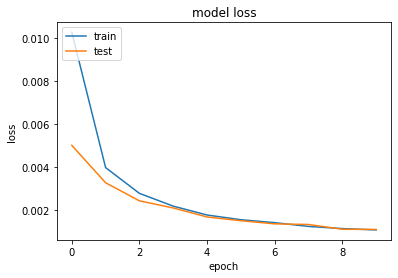

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./graphics/model_loss.png')
plt.show()

## Function to Check Reconstructed Photos

In [23]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

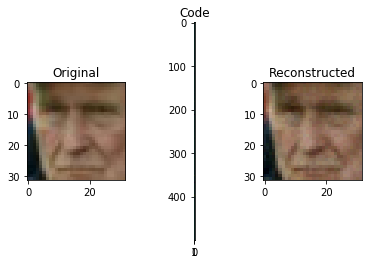

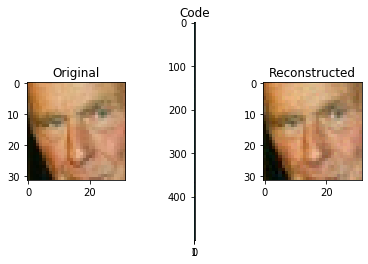

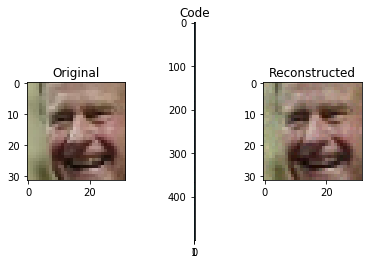

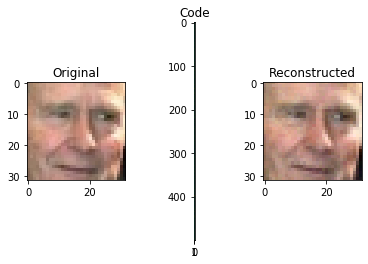

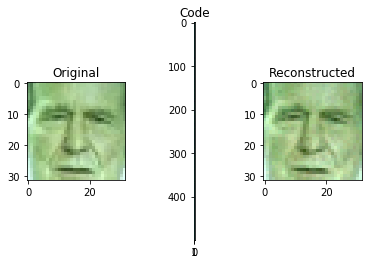

<Figure size 432x288 with 0 Axes>

In [24]:
def visualize(img,encoder,decoder,):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
   
    plt.show()
    plt.savefig('famous{}.png'.format(count))
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)

## Function to test the model with friends photos

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [ ]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            #input_img_resize=cv2.resize(input_img,(128,128))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(32,32))
            #face=face / 255.0 - 0.5
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data/ 255.0 - 0.5

In [ ]:
X = load_dataset("../data/fotop/")
X.shape

In [ ]:
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)